In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

files = os.listdir("plots/convergence/")
files = [f for f in files if f.endswith(".csv")]

def get_dataframes(dir):
    files = os.listdir(dir)
    files = [f for f in files if f.endswith(".csv")]
    for file in files:
        if "init" in file:
            df_init = pd.read_csv(dir+"/"+file)
        else:
            df_final = pd.read_csv(dir+"/"+file)
    return df_init, df_final

def get_pos(dir):
    files = os.listdir(dir)
    files = [f for f in files if f.endswith(".csv")]
    for file in files:
        if "init" in file:
            df = pd.read_csv(dir+"/"+file)
            init_pos = df.iloc[:, :3]
        else:
            df = pd.read_csv(dir+"/"+file)
            final_pos = df.iloc[:, :3]
    return np.array(init_pos.values), np.array(final_pos.values)

df_init, df_final = get_dataframes("plots/convergence/")
init_pos, final_pos = get_pos("plots/convergence/")

disp = final_pos - init_pos
print(init_pos.shape, final_pos.shape)

(100000, 3) (100000, 3)


### Displacements

Text(0, 0.5, 'Count')

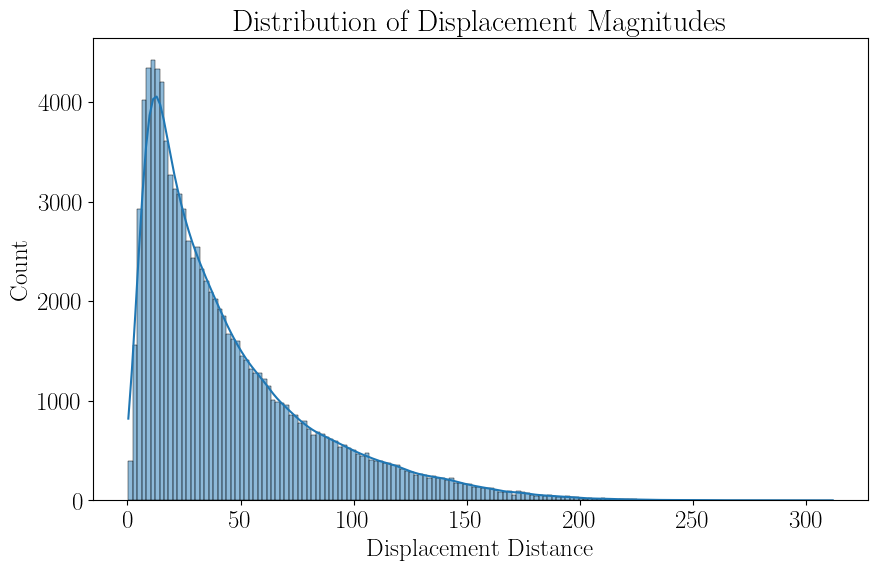

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsfonts}"
plt.rcParams["text.latex.preamble"] = r"\usepackage{amssymb}"
plt.rcParams["text.latex.preamble"] = r"\usepackage{graphicx}"
plt.rcParams["text.latex.preamble"] = r"\usepackage{siunitx}"

#set font size to 18
plt.rcParams["font.size"] = 18
plt.rcParams["font.family"] = "serif"

#legend font size to 12
plt.rcParams["legend.fontsize"] = 15

# Calculate displacement magnitudes
disp_magnitude = np.sqrt(np.sum(disp**2, axis=1))

# Plot distribution
plt.figure(figsize=(10, 6))
sns.histplot(disp_magnitude, kde=True)
plt.title('Distribution of Displacement Magnitudes')
plt.xlabel('Displacement Distance')
plt.ylabel('Count')

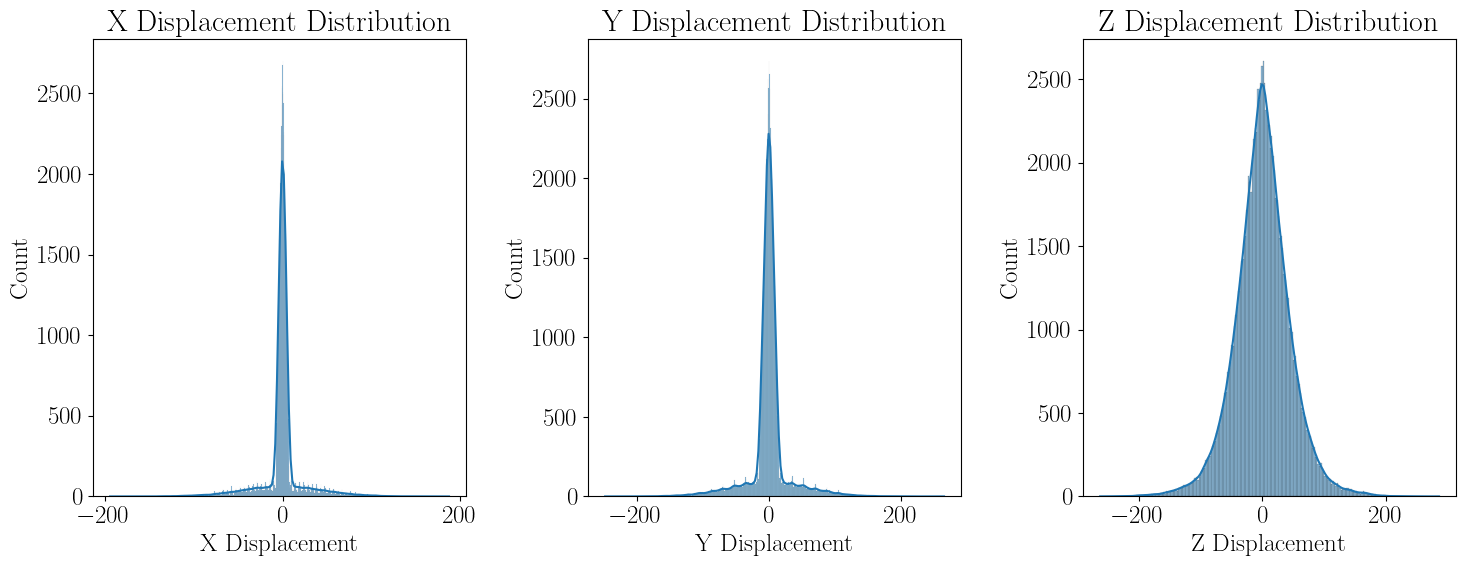

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
for i, dim in enumerate(['X', 'Y', 'Z']):
    sns.histplot(data=disp[:, i], kde=True, ax=axes[i])
    axes[i].set_title(f'{dim} Displacement Distribution')
    axes[i].set_xlabel(f'{dim} Displacement')
plt.tight_layout()

In [5]:
def get_phases(df):
    phases = df.iloc[:,3:6]
    phases = np.array(phases.values)
    return phases

phases = get_phases(df_final)
print(phases.shape)

(100000, 3)


### Diffusion Tensor fitting

In [6]:
def get_parameters(tensor, bvalue=0.299181):
    # Main computation
    D, eigenvectors = np.linalg.eig(tensor)
    sorted_indices = np.argsort(D)[::-1]
    eigenvalues_sorted = D[sorted_indices]
    eigenvectors_sorted = eigenvectors[:, sorted_indices]
    lambda1, lambda2, lambda3 = eigenvalues_sorted
    # Assuming lambda1, lambda2, and lambda3 are the eigenvalues of the diffusion tensor
    lambda_mean = (lambda1 + lambda2 + lambda3) / 3

    # Compute the numerator of the FA formula
    numerator = np.sqrt((lambda1 - lambda_mean)**2 + (lambda2 - lambda_mean)**2 + (lambda3 - lambda_mean)**2)

    # Compute the denominator of the FA formula
    denominator = np.sqrt(lambda1**2 + lambda2**2 + lambda3**2)

    # Calculate the Fractional Anisotropy (FA)
    FA = np.sqrt(3 / 2) * (numerator / denominator)
    
    return FA, lambda_mean, lambda1, lambda2, lambda3, eigenvectors_sorted

def process_phase(phase, bvalue):
    
    directions = np.array([
        [1, 1, 0],
        [1, -1, 0],
        [1, 0, 1],
        [1, 0, -1],
        [0, 1, 1],
        [0, 1, -1]
    ])
    
    ndirs = directions.shape[0]
    b_matrix = np.zeros((ndirs, 6))
    signal_ratio = np.zeros(ndirs)
    
    for i in range(ndirs):
        dir = directions[i, :]  # [Gx, Gy, Gz]
        b_matrix[i, :] = np.concatenate([dir**2, 2*dir[[0, 0, 1]]*dir[[1, 2, 2]]]) * bvalue
        phi = np.sum(phase * dir, axis=1)
        signal_ratio[i] = np.abs(np.mean(np.exp(-1j * phi)))
    
    # Least squares solution
    A = b_matrix
    b = np.log(signal_ratio + 1e-8)
    x = -np.linalg.lstsq(A, b,rcond=None)[0]  # solve
    
    # x = [Dxx,Dyy,Dzz,Dxy,Dxz,Dyz]
    tensor = np.zeros((3, 3))
    tensor[0, 0] = x[0]
    tensor[1, 1] = x[1]
    tensor[2, 2] = x[2]
    tensor[0, 1] = tensor[1, 0] = x[3] 
    tensor[0, 2] = tensor[2, 0] = x[4]
    tensor[1, 2] = tensor[2, 1] = x[5]
    return tensor

In [7]:
tensor = process_phase(phases, 0.299181)
FA, lambda_mean, lambda1, lambda2, lambda3, eigenvectors = get_parameters(tensor)
print(FA, lambda_mean, lambda1, lambda2, lambda3)


0.6394277221174409 0.468335418189673 0.8705514767934294 0.3114070924178237 0.22304768535776587


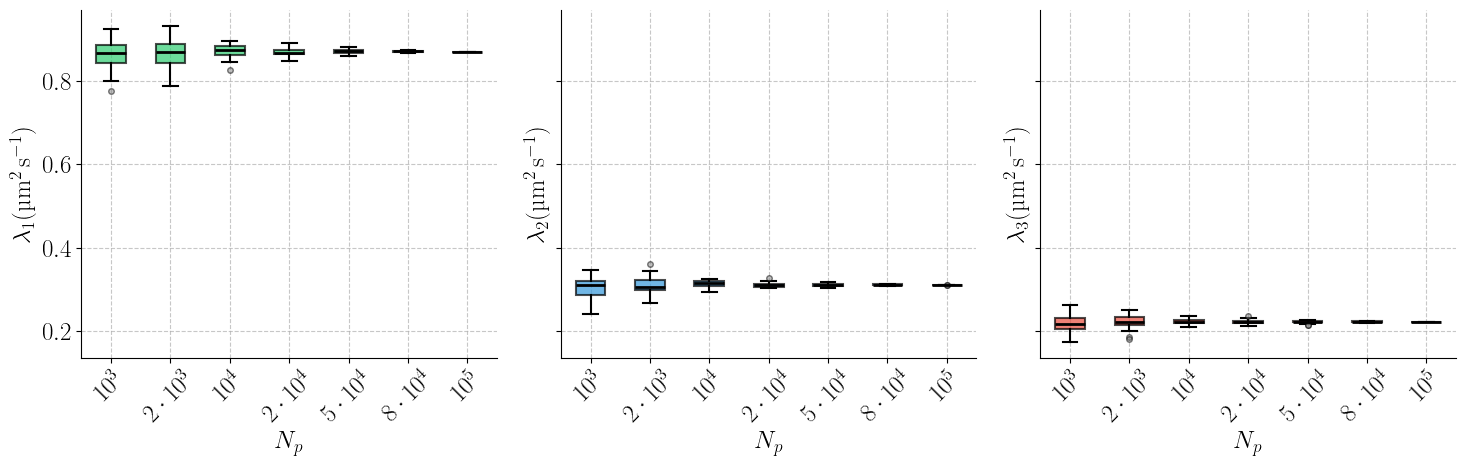

In [8]:
plt.rcParams['text.usetex'] = True
#add siunitx
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{siunitx}'

# Add after your existing code
def convergence_analysis(phases, n_iterations=50, sample_sizes=None):
    if sample_sizes is None:
        # Create logarithmically spaced sample sizes
        sample_sizes = [1000,2000,10000,20000,50000,80000,100000]
        sample_sizes = np.unique(sample_sizes)  # Remove duplicates
    
    # Initialize arrays to store results
    results = {
        'FA': np.zeros((len(sample_sizes), n_iterations)),
        'lambda1': np.zeros((len(sample_sizes), n_iterations)),
        'lambda2': np.zeros((len(sample_sizes), n_iterations)),
        'lambda3': np.zeros((len(sample_sizes), n_iterations)),
        'lambda_mean': np.zeros((len(sample_sizes), n_iterations))
    }
    
    # For each sample size
    for i, size in enumerate(sample_sizes):
        for j in range(n_iterations):
            # Randomly sample particles
            idx = np.random.choice(len(phases), size=size, replace=False)
            sampled_phases = phases[idx]
            
            # Process and get parameters
            tensor = process_phase(sampled_phases, 0.299181)
            FA, lambda_mean, l1, l2, l3, _ = get_parameters(tensor)
            
            # Store results
            results['FA'][i, j] = FA
            results['lambda1'][i, j] = l1
            results['lambda2'][i, j] = l2
            results['lambda3'][i, j] = l3
            results['lambda_mean'][i, j] = lambda_mean
    
    return sample_sizes, results

# Run the analysis
sample_sizes, results = convergence_analysis(phases)
# Plot the convergence
fig, axes = plt.subplots(1, 3, figsize=(15, 5),sharey="row")
axes = axes.flatten()
# Create positions for x-axis (using range)
positions = range(len(sample_sizes))
#sample_sizes = [1000,2000,10000,20000,50000,80000,100000]
labels = ["$10^4$","$2 \\cdot 10^4$","$10^5$","$2 \\cdot 10^5$","$5 \\cdot 10^5$", "$8 \\cdot 10^5$", "$10^6$"]
colors = ['#2ecc71', '#3498db', '#e74c3c']  # Green, Blue, Red
box_properties = {
    'boxprops': {'facecolor': 'white', 'alpha': 0.8, 'edgecolor': 'black', 'linewidth': 1.5},
    'medianprops': {'color': 'black', 'linewidth': 2},
    'whiskerprops': {'color': 'black', 'linewidth': 1.5},
    'capprops': {'color': 'black', 'linewidth': 1.5},
    'flierprops': {'marker': 'o', 'markerfacecolor': 'gray', 'markersize': 4, 'alpha': 0.5}
}

for idx, (key, title) in enumerate([
    ('lambda1', '$\lambda_1 (\SI{}{\micro\meter\squared\per\second})$'), 
    ('lambda2', '$\lambda_2 (\SI{}{\micro\meter\squared\per\second})$'), 
    ('lambda3', '$\lambda_3 (\SI{}{\micro\meter\squared\per\second})$')
]):
    if key is None:
        continue
    ax = axes[idx]
    # Create boxplot with custom style
    bp = ax.boxplot([results[key][i, :] for i in range(len(sample_sizes))], 
                    positions=positions,
                    patch_artist=True,  # Required for filling boxes with color
                    **box_properties)
    
    # Color the boxes
    for patch in bp['boxes']:
        patch.set_facecolor(colors[idx])
        patch.set_alpha(0.7)
    
    # Customize the plot
    ax.set_xticks(positions, labels=labels, rotation=45)
    ax.set_xlabel("$N_p$")
    ax.set_ylabel(title)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("convergence.png",dpi=400)

### Strain convergence

In [1]:
import os
import numpy as np
import pandas as pd
import re

dir = os.getcwd()
files = os.listdir(dir)
files = [f for f in files if f.endswith(".csv")]

steps = [0.1,1.,10.,100.,250.,500.,1000]
state = "relaxed"
ecv = "0.25"

def get_df_array(dir, files, steps):
    df_array_init = {step: [] for step in steps}
    df_array_final = {step: [] for step in steps}
    
    for file in files:
        pattern_timestep = r"*step_(\d+\.?\d*)_.*_(\d)_(init|final)\.csv"
        match = re.search(pattern_timestep, dir+"/"+file)
        strain_step = float(match.group(1))
        seed = int(match.group(2))# Would give you 100.0
        file_type = match.group(3) 
        print(strain_step,seed,file_type)# Would give you "init"
        if strain_step not in steps:
            continue
        if file_type == "init":
            df_array_init[strain_step].append(pd.DataFrame(pd.read_csv(dir+"/"+file)))
        if file_type == "final":
            df_array_final[strain_step].append(pd.DataFrame(pd.read_csv(dir+"/"+file)))
    return df_array_init, df_array_final

df_array_init, df_array_final = get_df_array(dir, files, steps)
for key, val in df_array_final.items():
    print(key,len(val))

error: nothing to repeat at position 0

In [14]:
from tqdm import tqdm 

def get_disp_phase(df_array_init, df_array_final, steps):
    disp, phase = {step: [] for step in steps}, {step: [] for step in steps}
    for step in steps:
        df_init = df_array_init[step][0]
        df_final = df_array_final[step][0]
        disp[step] = df_final.iloc[:, :3] - df_init.iloc[:, :3]
        phase[step] = df_final.iloc[:, 3:6]
    return disp, phase

#That will be for each strain step
def bootstrap_dti_params(phases, n_bootstrap=100, desc="Bootstrapping"):
    pbar = tqdm(range(n_bootstrap),desc=desc)
    FA_boot = np.zeros(n_bootstrap)
    lambda_mean_boot = np.zeros(n_bootstrap)
    lambda1_boot = np.zeros(n_bootstrap)
    lambda2_boot = np.zeros(n_bootstrap)
    lambda3_boot = np.zeros(n_bootstrap)
    dict_values = {}
    for i in pbar:
        #index = np.arange(len(phases))
        index = np.random.choice(len(phases), size=len(phases), replace=True)
        phases_boot = phases[index]
        tensor = process_phase(phases_boot, 0.299181)
        FA, lambda_mean, l1, l2, l3, _ = get_parameters(tensor)
        FA_boot[i] = FA
        lambda_mean_boot[i] = lambda_mean
        lambda1_boot[i] = l1
        lambda2_boot[i] = l2
        lambda3_boot[i] = l3
    
    dict_values["FA"] = FA_boot
    dict_values["lambda_mean"] = lambda_mean_boot
    dict_values["lambda1"] = lambda1_boot
    dict_values["lambda2"] = lambda2_boot
    dict_values["lambda3"] = lambda3_boot
    
    return dict_values

disp_strain, phase_strain = get_disp_phase(df_array_init, df_array_final, steps)
results = {}
for step in steps:
    phases = phase_strain[step]
    phases = np.array(phases)
    dict_values = bootstrap_dti_params(phases, desc=f"Bootstraping {step}",n_bootstrap=100)
    results[step] = dict_values
    
#Results contains a dict for each step. The dict contains each param bootstraped

IndexError: list index out of range

In [22]:
dataframes = [pd.DataFrame() for i in range(len(steps))]
for k,step in enumerate(steps):
    for i,param in enumerate(["FA","lambda1","lambda2","lambda3","lambda_mean"]):
        param_values = results[step][param]
        param_values = np.array(param_values)
        if i == 0:
            n_bootstrap = int(param_values[0]) # Number of bootstrap samples
            dataframes[k] = pd.DataFrame(index=range(n_bootstrap))
        dataframes[k][param] = param_values
    dataframes[k]["step"] = step
    
final_dataframe = pd.concat(dataframes,ignore_index=True)
final_dataframe.describe()


,FA,lambda1,lambda2,lambda3,lambda_mean,step
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,0.690175,0.982974,0.302389,0.217728,0.501030,265.871429
std,0.024698,0.046683,0.009809,0.003833,0.011876,344.128701
min,0.623961,0.856160,0.287435,0.208051,0.466491,0.100000
25%,0.696252,0.992351,0.296289,0.215099,0.502041,1.000000
50%,0.699652,1.000194,0.298817,0.217383,0.505047,100.000000
75%,0.701981,1.006100,0.304132,0.219769,0.507331,500.000000
max,0.708605,1.023895,0.330900,0.229380,0.515298,1000.000000


<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:18: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_1910736/3149696604.py:5: SyntaxWarning: invalid escape sequence '\l'
  titles = ["FA","MD","$\lambda_1$"]
/tmp/ipykernel_1910736/3149696604.py:18: SyntaxWarning: invalid escape sequence '\D'
  ax.set_xlabel('$\Delta_{\epsilon}$')


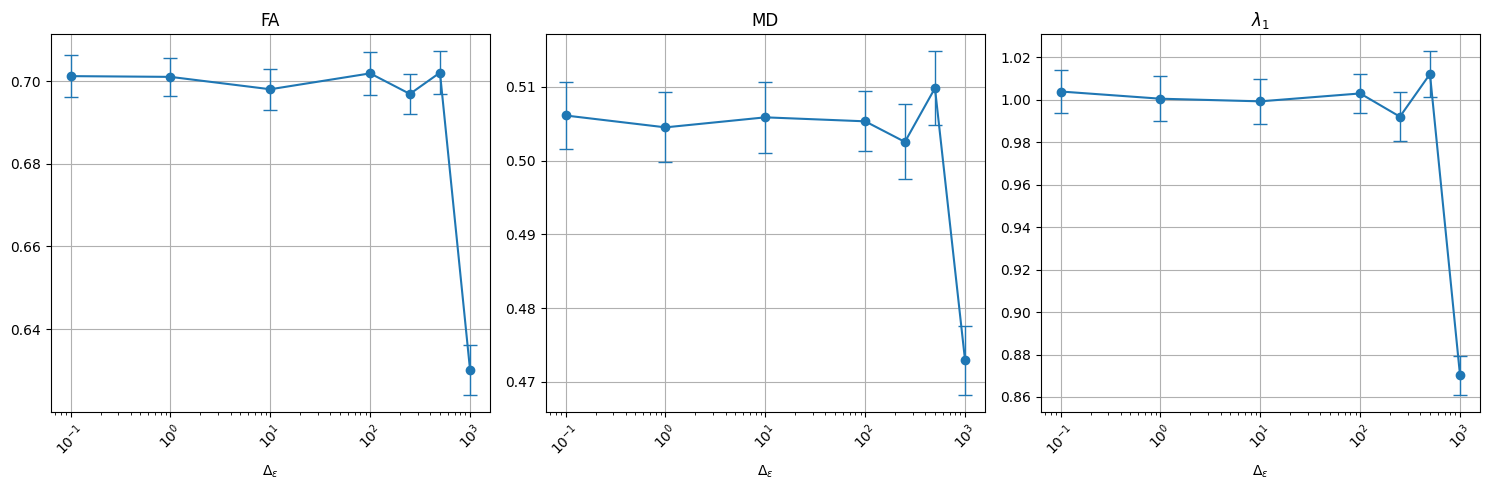

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()
titles = ["FA","MD","$\lambda_1$"]
for idx, param in enumerate(['FA', 'lambda_mean','lambda1']):
    ax = axes[idx]
    
    # Calculate means and standard deviations for each step
    means = final_dataframe.groupby('step')[param].mean()
    stds = final_dataframe.groupby('step')[param].std()
    
    # Plot errorbar with 2 standard deviations
    ax.errorbar(means.index, means.values, yerr=2*stds.values, 
               fmt='o-', capsize=5, capthick=1, elinewidth=1)
    
    ax.set_title(f'{titles[idx]}')
    ax.set_xlabel('$\Delta_{\epsilon}$')
    ax.set_xscale('log')  # Optional: use log scale for better visualization of steps
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

In [13]:
import matplotlib.pyplot as plt
FA_values = [results[step]["FA"] for step in steps]
FA_values = np.array(FA_values)
print(FA_values.shape)
FA_means = []
for i,step in enumerate(steps):
    FA_array = FA_values[i,:]
    FA_mean = np.mean(FA_array)
    FA_means.append(FA_mean)
    FA_std = np.std(FA_array,axis=0)
    print(f"Step {step}: Mean: {FA_mean:.3f}, Std: {FA_std:.6f}")
print(FA_means)
print(steps)

(7, 1)
Step 0.1: Mean: 0.702, Std: 0.000000
Step 1: Mean: 0.702, Std: 0.000000
Step 5: Mean: 0.703, Std: 0.000000
Step 10: Mean: 0.699, Std: 0.000000
Step 50: Mean: 0.706, Std: 0.000000
Step 100: Mean: 0.702, Std: 0.000000
Step 500: Mean: 0.703, Std: 0.000000
[0.7015494506846043, 0.7017978801781197, 0.7029968317929076, 0.6987901744279134, 0.705913807736186, 0.7020388801500543, 0.7025371753082411]
[0.1, 1, 5, 10, 50, 100, 500]


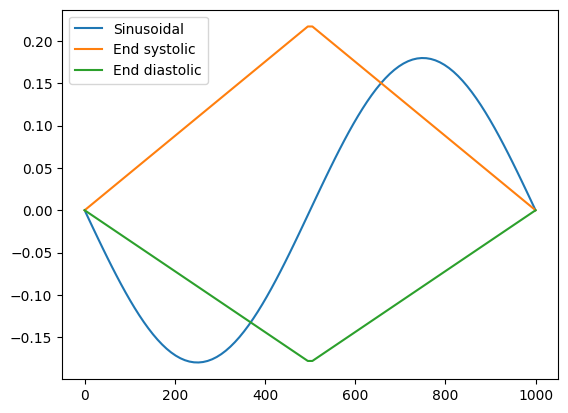

In [71]:
time = np.linspace(0,1000,100)

def sinusoidal_strain(time):
    if time <= 500:
        return -0.18*np.sin(time/500*np.pi)
    else:
        return 0.18*np.sin((time-500)/500*np.pi)

def end_systolic_strain(time):
    if time<500:
        return (time/500)*(0.2195)
    else:
        return 0.2195 - (time-500)/500*(0.2195)
    
def end_diastolic_strain(time):
    if time<500:
        return time/500*-0.18
    else:
        return (0.18/500)*(time-500) - 0.18
    
def vectorize_strain(strain):
    return np.vectorize(strain)

sinusoidal_strain = vectorize_strain(sinusoidal_strain)
end_systolic_strain = vectorize_strain(end_systolic_strain)
end_diastolic_strain = vectorize_strain(end_diastolic_strain)

plt.plot(time, sinusoidal_strain(time),label="Sinusoidal")
plt.plot(time, end_systolic_strain(time),label="End systolic")
plt.plot(time, end_diastolic_strain(time),label="End diastolic")
plt.legend()
plt.show()
